In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('mindvalley_tweets.csv')
df.head()

,Unnamed: 0,tweet
0,0,"@Vishen , a CEO that I would REALLY love to he..."
1,1,The latest episode of the @mindvalley podcast ...
2,2,@ImPaulMcKenna @mindvalley A new way of learni...
3,3,@moneyman11_c @Vishen @mindvalley What is real...
4,4,@manojaryan @Vishen @mindvalley It messed with...


In [3]:
df.fb_comment.replace("\S*http\S*" , "", regex=True, inplace = True)
df.tweet.replace("_" , " ", regex=True, inplace = True)
df.tweet.replace("^" , " ", regex=True, inplace = True)

In [ ]:
for i in string.punctuation:
    try:
        df.fb_comment.replace(f"\{i}" , "", regex=True, inplace = True)
    except: pass

In [4]:
df.tweet.head()

0     @Vishen , a CEO that I would REALLY love to h...
1     The latest episode of the @mindvalley podcast...
2     @ImPaulMcKenna @mindvalley A new way of learn...
3     @moneyman11 c @Vishen @mindvalley What is rea...
4     @manojaryan @Vishen @mindvalley It messed wit...
Name: tweet, dtype: object

In [5]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [6]:
def word_root(text):
    list_data3=[]
    text = remove_unicode(text)
    doc = spaci(text)
    for token in doc:
        if token.text.isalpha():
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(str(x).lower()))  

In [7]:
df.tweet[0]

'a ceo that I would really love to hear on your podcast and possibly even have a course on be his philosophy be well align to the empathy that mindvalley inspire thank you for consider this request'

In [8]:
df_clean = df.tweet
df_clean.shape

(406,)

In [9]:
df_clean = df_clean.dropna()
df_clean.shape

(406,)

In [10]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [11]:
from sentence_transformers import SentenceTransformer

In [12]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [13]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
# embeddings1[embeddings1.argmax()]

In [15]:
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [16]:
model=SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
embeddings3 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [17]:
model=SentenceTransformer('allenai-specter')
embeddings4 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [18]:
UMAP_bert1 = umap.UMAP(n_components=5).fit_transform(embeddings1)

UMAP_bert2 = umap.UMAP(n_components=5).fit_transform(embeddings2)

UMAP_bert3 = umap.UMAP(n_components=5).fit_transform(embeddings3)

UMAP_bert4 = umap.UMAP(n_components=5).fit_transform(embeddings4)

#n_neighbors=10, min_dist=0.0, 

In [20]:
from pyclustertend import hopkins

embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert2" : UMAP_bert2,
              "UMAP_bert3" : UMAP_bert3, "UMAP_bert4" : UMAP_bert4}
              
embeds = {}

for key, emb in embeddings.items():
    embeds[key] = hopkins(emb,emb.shape[0])

embeds
# embeddings[embeds.index(min(embeds))]
# print(f"the hopkins score for embeddings {i} is : {hs}")

{'UMAP_bert1': 0.12565436543053835,
 'UMAP_bert2': 0.1773678372842005,
 'UMAP_bert3': 0.20621921118770117,
 'UMAP_bert4': 0.152493836932999}

In [21]:
best_embed_name = min(embeds, key=embeds.get)
# best_embed_name = 'UMAP_bert3'
best_model = embeddings[best_embed_name]
best_embed_name

'UMAP_bert1'

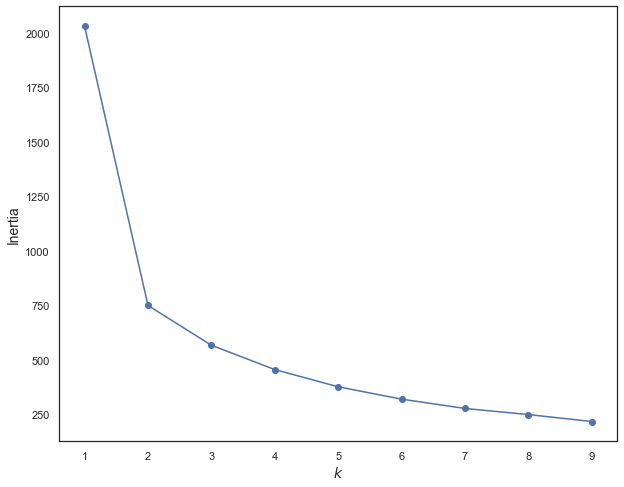

In [22]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [36]:
cluster = KMeans(n_clusters=3, init="k-means++").fit_predict(best_model)

In [37]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings3)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Spectral')
    plt.show()

{0: 187, 1: 127, 2: 92}


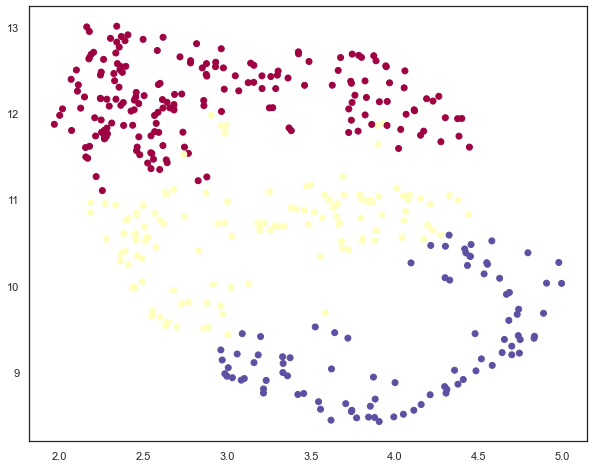

In [38]:
plot()

In [43]:
docs = pd.DataFrame(df_clean)
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})
labeled_docs.tweet.replace(r"\S*octop\S*", "", regex=True, inplace = True)
labeled_docs

,cluster,tweet
0,0,a ceo that I would really love to hear on your...
1,1,a new way of learning well and well every day ...
2,2,c what be reality transurfe exactly it mess wi...


In [44]:
from keybert import KeyBERT
array_text = labeled_docs.tweet.tolist()

model_names = {"model1":'distilbert-base-nli-mean-tokens',
               "model2": "xlm-r-distilroberta-base-paraphrase-v1" ,
               "model3": 'roberta-large-nli-stsb-mean-tokens',
               "model4": "allenai-specter"}
    
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,min_df=2
                                             stop_words=["motivatemewithlynetterenda",
                                                         "marc_campbellhttpstcozqeefjcmrn",
                                                         "minddevelopmentacademy",
                                                         "mindfulnessatwork"])
    if not keywords:
        k -= 1
    else:
        print("Cluster", str(k))
        print([word[0] for word in keywords])

Cluster 1
['podcast', 'excellent', 'program', 'episode', 'awesome', 'twitter', 'buddy', 'badass', 'youtube', 'amazing']
Cluster 2
['believeinyourself', 'loveyourself', 'thankful', 'luck', 'talent', 'talente', 'amazing', 'thank', 'excellence', 'gratitude']
Cluster 3
['thank', 'enjoy', 'stop', 'video', 'awesome', 'amazing', 'wonderful', 'badass', 'wow', 'fav']


In [46]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,min_df=2,keyphrase_ngram_range=(1, 2),
                                             stop_words=["motivatemewithlynetterenda",
                                                         "marc_campbellhttpstcozqeefjcmrn",
                                                         "minddevelopmentacademy",
                                                         "mindfulnessatwork"])
    if not keywords:
        k -= 1
    else:
        print("Cluster", str(k))
        print([word[0] for word in keywords])

Cluster 1
['fav podcast', 'fun podcast', 'my podcast', 'be podcast', 'like podcast', 'the podcast', 'entire podcast', 'your podcast', 'of podcast', 'favorite podcast']
Cluster 2
['improve myself', 'meilleur talent', 'good luck', 'thankful always', 'mindcoach loveyourself', 'believeinyourself lifecoachperth', 'explore luck', 'thank you', 'visione mastery', 'incredible thank']
Cluster 3
['stop thank', 'content thank', 'enjoy my', 'we love', 'thank for', 'love this', 'thank you', 'thank awesome', 'really love', 'today thank']


In [47]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,min_df=2,keyphrase_ngram_range=(1, 2),
                                             stop_words=["motivatemewithlynetterenda",
                                                         "marc_campbellhttpstcozqeefjcmrn",
                                                         "minddevelopmentacademy",
                                                         "mindfulnessatwork"])
    if not keywords:
        k -= 1
    else:
        print("Cluster", str(k))
        print([word[0] for word in keywords])

Cluster 1
['fav podcast', 'fun podcast', 'my podcast', 'be podcast', 'like podcast', 'the podcast', 'entire podcast', 'your podcast', 'of podcast', 'favorite podcast']
Cluster 2
['improve myself', 'meilleur talent', 'good luck', 'thankful always', 'mindcoach loveyourself', 'believeinyourself lifecoachperth', 'explore luck', 'thank you', 'visione mastery', 'incredible thank']
Cluster 3
['stop thank', 'content thank', 'enjoy my', 'we love', 'thank for', 'love this', 'thank you', 'thank awesome', 'really love', 'today thank']
